In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

/kaggle/input/tweets-with-sarcasm-and-irony/train.csv
/kaggle/input/tweets-with-sarcasm-and-irony/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical

2024-05-10 19:03:42.580989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 19:03:42.581103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 19:03:42.710087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TRAIN Dataset: (81408, 2)
VAL Dataset: (8119, 2)


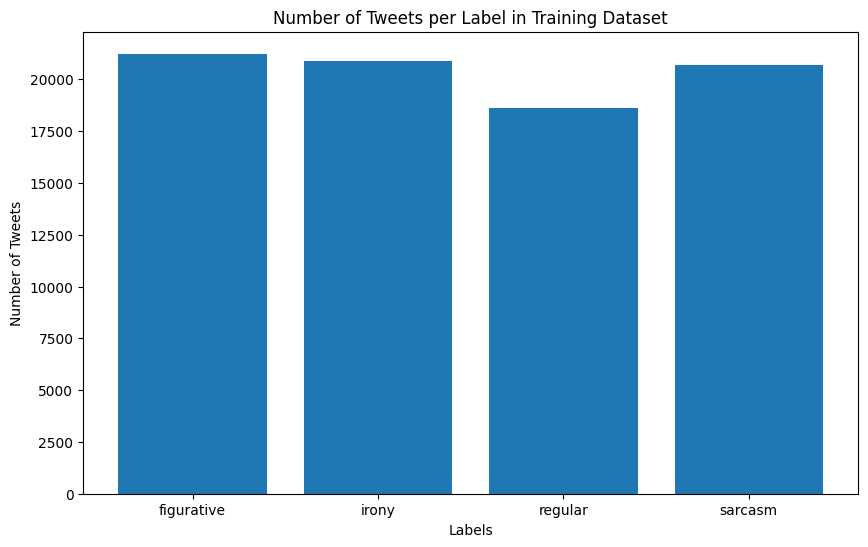

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('/kaggle/input/tweets-with-sarcasm-and-irony/train.csv')
test_data = pd.read_csv('/kaggle/input/tweets-with-sarcasm-and-irony/test.csv')

# Remove rows where 'tweets' or 'class' columns are NaN
train_data = train_data.dropna(subset=['tweets', 'class'])
test_data = test_data.dropna(subset=['tweets', 'class'])

# Normalize class labels to lower case
train_data['class'] = train_data['class'].str.lower()
test_data['class'] = test_data['class'].str.lower()

# Create a unified set of labels from both train and test data to ensure consistent mapping
all_labels = pd.concat([train_data['class'], test_data['class']])
unique_labels = all_labels.unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# Map the labels using the unified label map
train_data['class'] = train_data['class'].map(label_map)
test_data['class'] = test_data['class'].map(label_map)

# Prepare datasets
train_df = train_data[['tweets', 'class']].copy()
test_df = test_data[['tweets', 'class']].copy()

train_dataset = train_df.reset_index(drop=True)
val_dataset = test_df.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VAL Dataset: {}".format(val_dataset.shape))

# Plotting the number of tweets per label for the train dataset
label_counts = train_dataset['class'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, tick_label=[unique_labels[idx] for idx in label_counts.index])
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Label in Training Dataset')
plt.show()

In [4]:
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import nn
import torch

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.tweets = dataframe.tweets
        self.targets = self.data['class']
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, index):
        text = str(self.tweets[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_dataset = CustomDataset(train_dataset, tokenizer, 20)
val_dataset = CustomDataset(val_dataset, tokenizer, 20)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)
    
    
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.targets.to_numpy()),  # Convert Pandas Series to NumPy array
    y=train_dataset.targets.to_numpy()  # Convert Pandas Series to NumPy array
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Modify the loss function to include class weight
def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss(weight=class_weights_tensor)(outputs, targets)
    
model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), num_classes=4)
model.to(device)

def loss_fn(outputs, targets):
    return nn.CrossEntropyLoss(weight=class_weights_tensor)(outputs, targets)

LEARNING_RATE = 1e-05
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss, total_accuracy = 0, 0
    for _, data in enumerate(dataloader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        total_accuracy += (preds == targets).sum().item()
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset)
    return avg_loss, avg_accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss, total_accuracy = 0, 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for _, data in enumerate(dataloader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            preds = torch.argmax(outputs, dim=1)
            total_accuracy += (preds == targets).sum().item()
            total_loss += loss.item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset)
    return avg_loss, avg_accuracy, all_targets, all_predictions

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Now training


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/5
Train Loss: 0.87175, Train Accuracy: 0.58608
Validation Loss: 0.83235, Validation Accuracy: 0.61128
Epoch 2/5
Train Loss: 0.76790, Train Accuracy: 0.62861
Validation Loss: 0.81460, Validation Accuracy: 0.62532
Epoch 3/5
Train Loss: 0.68938, Train Accuracy: 0.66019
Validation Loss: 0.82088, Validation Accuracy: 0.61830
Epoch 4/5
Train Loss: 0.61731, Train Accuracy: 0.68818
Validation Loss: 0.92868, Validation Accuracy: 0.61522
Epoch 5/5
Train Loss: 0.56445, Train Accuracy: 0.71026
Validation Loss: 0.96368, Validation Accuracy: 0.60537
              precision    recall  f1-score   support

           0       0.14      0.02      0.04      2044
           1       0.54      0.77      0.63      2111
           2       0.91      0.84      0.88      1859
           3       0.55      0.80      0.65      2105

    accuracy                           0.61      8119
   macro avg       0.54      0.61      0.55      8119
weighted avg       0.53      0.61      0.54      8119



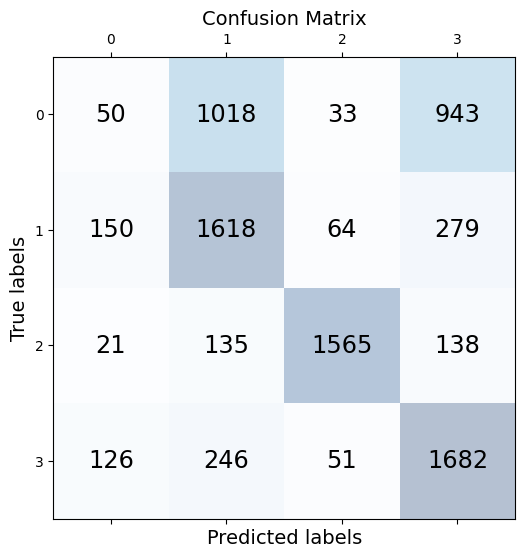

In [8]:
# Training and validation loop
print("Now training")
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, optimizer, device)
    val_loss, val_acc, all_targets, all_predictions = evaluate(model, val_dataloader, device)
    
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Train Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.5f}')
    print(f'Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_acc:.5f}')

# At the end of training, print classification report and plot the confusion matrix
print(classification_report(all_targets, all_predictions))
conf_mat = confusion_matrix(all_targets, all_predictions)
fig, ax = plt.subplots(figsize=(8, 6))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.show()